## imports & file load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re
import warnings
warnings.filterwarnings('ignore')

def minMaxScale(data, imposed_minimum = None, imposed_maximum = None, fit = False): #min max scaling
    mini = min(data)
    maxi = max(data)
    
    if (imposed_minimum != None): mini = imposed_minimum
    if (imposed_maximum != None): maxi = imposed_maximum
    if (fit == False):
        return (data - mini)/(maxi - mini)
    else: 
        return [mini, maxi]

In [2]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)

In [3]:
display(data.sample())

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj
40554,Seth Green,M,1974-02-08,Idle Hands,1999.0,4152230.0,92.0,6.925,44932,"[' ""Thriller""', ' ""Horror""', ' ""Comedy""}']","[' ""United States of America""}']",6.017725e+06


## actor metrics calculation & timeScores old star score values

first we need to deflate the imdb ratings by the amount of votes they've gotten

#### revenue rating appearances & old scores

In [4]:
data['numVotes_factor'] = minMaxScale(np.log(data['numVotes']), 0)
data['averageRating_adj'] =  data['averageRating']* data['numVotes_factor']

In [5]:
data['actor'] = data["Actor_name"].apply(lambda x : '_'.join(x.split())) #simplifying actor names

actorMetrics = pd.DataFrame(data['actor'].drop_duplicates().reset_index(drop = True)) #creation of starscore dataf

timeScores = pd.DataFrame(data['actor'].drop_duplicates().reset_index(drop = True))

In [6]:
metrics_avg = { 'box_office_adj' : 'revenue_avg', 'averageRating_adj' : 'grade_avg'}
metrics_sum = { 'box_office_adj' : 'revenue_sum', 'averageRating_adj' : 'grade_sum'}

for idx, (key, value) in enumerate(metrics_avg.items()):
    print(idx)
    lists_per_actor = data.groupby('actor').apply(lambda x : np.mean(x[key])).reindex(
        index = actorMetrics['actor'].values)
    actorMetrics[value] = lists_per_actor.values
       
for idx, (key, value) in enumerate(metrics_sum.items()):
    print(idx)
    lists_per_actor = data.groupby('actor').apply(lambda x : sum(x[key])).reindex(
        index = actorMetrics['actor'].values)
    actorMetrics[value] = lists_per_actor.values
    
    
appearances_per_actor = data.groupby('actor')['Movie_name'].count().reindex(
    index = actorMetrics['actor'].values).reset_index(drop = True)
actorMetrics['appearances'] = appearances_per_actor

0
1
0
1


In [7]:
longitudinal_interest_columns = {'box_office_adj': 'revenues',
                                 'Movie_release_date': 'movie_years', 'averageRating_adj': 'ratings'}

for idx, (key, value) in enumerate(longitudinal_interest_columns.items()):
    
    lists_per_actor = data.groupby('actor').apply(lambda x : pd.Series({key: x[key].values})).reindex(
        index = timeScores['actor'].values)
    timeScores[value] = lists_per_actor.values
    
#for col in longitudinal_interest_columns:
#  per_month[col] = selected_T4_ds.groupby('date_transformed').apply(lambda x: pd.Series({col: x[col].values }))

In [8]:
#to access a list :
#star_scores.query('actor == "Bruce_Willis"')['cumulative_revenue'].tolist()[0]
timeScores['cumulative_revenue'] = timeScores['revenues'].apply(lambda x : np.cumsum(x.tolist()))
timeScores['cumulative_ratings'] = timeScores['ratings'].apply(lambda x : np.cumsum(x.tolist()))

Example

In [9]:
timeScores.query('actor == "Bruce_Willis"')

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings
6221,Bruce_Willis,"[134943125.0, 83663223.40425533, 287281542.857...","[1982.0, 1987.0, 1988.0, 1988.0, 1989.0, 1989....","[5.234449774801497, 4.962270978137284, 6.85023...","[134943125.0, 218606348.40425533, 505887891.26...","[5.234449774801497, 10.19672075293878, 17.0469..."


In [10]:
timeScores['star_score'] = timeScores.apply(lambda x : np.log(x['cumulative_revenue'] * x['cumulative_ratings']),
                                            axis = 1)

In [11]:
timeScores.query('actor == "Bruce_Willis"').star_score.tolist()[0]

array([20.37562569, 21.52484935, 22.87779702, 23.16592681, 24.12066325,
       24.26186786, 24.43932385, 24.56774033, 25.03784568, 25.2167668 ,
       25.30309363, 25.38607554, 25.46254964, 25.68328199, 25.77828745,
       26.036364  , 26.09157519, 26.17052271, 26.23243044, 26.31510454,
       26.5161436 , 26.64345161, 26.91925832, 27.00653395, 27.0804974 ,
       27.11396059, 27.16636472, 27.40796109, 27.51062805, 27.57391951,
       27.63694881, 27.68006898, 27.71417254, 27.74477298, 27.79129007,
       27.86342092, 27.88950847, 27.98411682, 27.99370224, 28.03477429,
       28.08933249, 28.11001812, 28.14921902, 28.18301391, 28.25491294,
       28.27493007, 28.30365168, 28.38355376, 28.41081851, 28.43201317,
       28.45794694, 28.47418312, 28.51160685, 28.53836884, 28.57960625,
       28.63199162, 28.65012713, 28.68002949, 28.71376861, 28.76268324])

The formula for the star score is given below.

$star\ score = log\left(\overline{revenue} \cdot \overline{ratings_{normalized}}\right)$

To be noted that the star scored is defined on the 'career' of the actor, namely it is based on the average of the identified parameters over all his/her movies.

In [13]:
#log product = sum of log, we are using this because we have 2 very heavy tailed distributions

timeScores['score_sum'] = np.log(actorMetrics['revenue_sum'] * actorMetrics['grade_sum']) 
epfl_scaler = minMaxScale(timeScores['score_sum'], fit = True)
timeScores['EPFLsum'] = (minMaxScale(timeScores['score_sum']) * 5) + 1 #min max scaled to epfl standards

timeScores['score_avg'] = np.log(actorMetrics['revenue_avg'] * actorMetrics['grade_avg'])
timeScores['EPFLavg'] = (minMaxScale(timeScores['score_avg']) * 5) + 1

In [14]:
timeScores['EPFLsum_time'] = timeScores['star_score'].apply(
    lambda x: (5 * minMaxScale(x, epfl_scaler[0], epfl_scaler[1])) + 1)

In [15]:
display(timeScores.query('actor == "Bruce_Willis"').EPFLsum_time.tolist()[0][-1],
        timeScores.query('actor == "Bruce_Willis"')['EPFLsum'])

5.844767263785556

6221    5.844767
Name: EPFLsum, dtype: float64

#### genre, country & tenure to put in actorMetrics

`Main genre per actor`

In [16]:
# lets get better parse on genres 
data['genres_corrected'] = data['genres'].apply(lambda x: str(x).split('"')[1::2])

In [31]:
#list_to_join = data['genres_corrected'].values.tolist() #total genres not unique

In [18]:
genres_per_actor = data.groupby('actor').apply(
    lambda x :pd.Series({'genres': x['genres_corrected'].values})).reindex(index = timeScores['actor'].values)

timeScores['genres'] = genres_per_actor.values

In [19]:
genres_per_actor['genre_total'] = genres_per_actor['genres'].apply(lambda x : sum(x, [])).apply(
    lambda x : ['NaN'] if len(x) == 0 else x)

In [20]:
genres_per_actor['count_values'] = genres_per_actor['genre_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'gen' : x}).groupby(by = 'gen').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False)['count'].values)

In [21]:
genres_per_actor['unique_genres_order'] = genres_per_actor['genre_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'gen' : x}).groupby(by = 'gen').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False).index.tolist())

In [22]:
genres_per_actor['main'] = genres_per_actor['unique_genres_order'].apply(lambda x : x[0])
genres_per_actor['secondary'] = genres_per_actor['unique_genres_order'].apply(
    lambda x : x[1] if len(x) > 1 else None)

In [23]:
genres_to_merge = genres_per_actor.reset_index(drop = True)

In [24]:
#train a decision tree on the best actors, or hand made labels to get more interesting genres than costume drama

> tips for above : make group similar genres and reduce them

> Main country per actor

In [32]:
data['countries_cor'] = data['countries'].apply(lambda x: str(x).split('"')[1::2])

In [35]:
countries_per_actor = data.groupby('actor').apply(
    lambda x :pd.Series({'countries': x['countries_cor'].values})).reindex(index = timeScores['actor'].values)

timeScores['countries'] = countries_per_actor.values

In [37]:
countries_per_actor['country_total'] = countries_per_actor['countries'].apply(lambda x : sum(x, [])).apply(
    lambda x : ['NaN'] if len(x) == 0 else x)

In [38]:
countries_per_actor['count_values'] = countries_per_actor['country_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'con' : x}).groupby(by = 'con').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False)['count'].values)

In [39]:
countries_per_actor['unique_countries_order'] = countries_per_actor['country_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'con' : x}).groupby(by = 'con').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False).index.tolist())

In [40]:
countries_per_actor['main'] = countries_per_actor['unique_countries_order'].apply(lambda x : x[0])
countries_per_actor['secondary'] = countries_per_actor['unique_countries_order'].apply(
    lambda x : x[1] if len(x) > 1 else None)

In [45]:
countries_to_merge = countries_per_actor.reset_index(drop = True)

In [53]:
timeScores['genres'] = genres_to_merge['unique_genres_order']
timeScores['genre_count'] = genres_to_merge['count_values']
actorMetrics['main_genre'] = genres_to_merge['main']
actorMetrics['2nd_genre'] = genres_to_merge['secondary']
actorMetrics['country1'] = countries_to_merge['main']
actorMetrics['country2'] = countries_to_merge['secondary']

In [54]:
display(timeScores.sample(), actorMetrics.sample())

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,score_sum,EPFLsum,score_avg,EPFLavg,EPFLsum_time,genres,genre_count,countries
7287,Avner_the_Eccentric,[215051555.55555555],[1985.0],[4.522138740188265],[215051555.55555555],[4.522138740188265],[20.695373405169082],20.695373,3.743634,20.695373,4.683422,[3.743634298743781],"[Action, Action/Adventure, Adventure, Adventur...","[1, 1, 1, 1, 1, 1, 1]","[[United States of America, France, Morocco]]"


,actor,revenue_avg,grade_avg,revenue_sum,grade_sum,appearances,main_genre,2nd_genre,country1,country2
5527,Joe_Flaherty,3.886919e+07,4.008741,1.554768e+08,16.034963,4,Comedy,Action,United States of America,None


>tenure

In [59]:
l = [1, 2]
t = [2]
diff = t[0] - t[-1]
diff

0

In [60]:
actorMetrics['tenure'] = timeScores['movie_years'].apply(lambda x : abs(x[0] - x[-1]))

In [67]:
actorMetrics.query('actor == "Bruce_Willis"')

,actor,revenue_avg,grade_avg,revenue_sum,grade_sum,appearances,main_genre,2nd_genre,country1,country2,tenure
6221,Bruce_Willis,1.672831e+08,5.148966,1.003699e+10,308.937981,60,Thriller,Action,United States of America,Germany,30.0


In [66]:
print(timeScores.query('actor == "Bruce_Willis"')['movie_years'].tolist()[0][0],
      timeScores.query('actor == "Bruce_Willis"')['movie_years'].tolist()[0][-1])

1982.0 2012.0


## results

In [52]:
display(actorMetrics.head(3), timeScores.head(3))

,actor,revenue_avg,grade_avg,revenue_sum,grade_sum,appearances,main_genre,2nd_genre,country1,country2
0,Dustin_Farnum,6.117500e+06,2.861536,6.117500e+06,2.861536,1,Black-and-white,Drama,United States of America,None
1,Elmer_Clifton,1.250000e+09,4.791714,1.250000e+09,4.791714,1,Black-and-white,Costume drama,United States of America,None
2,Robert_Harron,1.250000e+09,4.791714,1.250000e+09,4.791714,1,Black-and-white,Costume drama,United States of America,None


,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,score_sum,EPFLsum,score_avg,EPFLavg,EPFLsum_time,genres,genre_count,countries
0,Dustin_Farnum,[6117500.0],[1914.0],[2.861536471788676],[6117500.0],[2.861536471788676],[16.67802278277362],16.678023,2.697314,16.678023,3.278702,[2.6973142737054587],"[Black-and-white, Drama, Indie, Silent film, W...","[1, 1, 1, 1, 1]",[[United States of America]]
1,Elmer_Clifton,[1250000000.0],[1915.0],[4.791714035959664],[1250000000.0],[4.791714035959664],[22.513297571992556],22.513298,4.217113,22.513298,5.319083,[4.217113125596666],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",[[United States of America]]
2,Robert_Harron,[1250000000.0],[1915.0],[4.791714035959664],[1250000000.0],[4.791714035959664],[22.513297571992556],22.513298,4.217113,22.513298,5.319083,[4.217113125596666],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",[[United States of America]]


## data saving & loading fixes

In [68]:
timeScores.to_csv('../data/timeScores.csv', sep = '\t')
actorMetrics.to_csv('../data/actorMetrics.csv')

> stop here if u just want metrics

In [35]:
savedTimeScores = pd.read_csv('../data/timeScores.csv', sep = '\t', index_col = 0)

In [36]:
display(savedTimeScores.query('actor == "Bruce_Willis"')['genres'].values.tolist()[0])
usual_suspects = timeScores.columns.tolist()[1: -2]
print(usual_suspects)

'[\'Thriller\', \'Action\', \'Drama\', \'Comedy\', \'Crime Fiction\', \'Action/Adventure\', \'Crime Thriller\', \'Mystery\', \'Adventure\', \'Romance Film\', \'Science Fiction\', \'Black comedy\', \'Gangster Film\', \'Action Thrillers\', \'Crime Comedy\', \'Suspense\', \'Family Film\', \'Comedy-drama\', \'Psychological thriller\', \'Buddy film\', \'Romantic comedy\', \'Period piece\', \'War film\', \'Indie\', \'Ensemble Film\', \'Fantasy\', \'Coming of age\', \'Film adaptation\', \'Horror\', \'Political drama\', \'Parody\', \'Heist\', \'Slapstick\', \'Marriage Drama\', \'Supernatural\', \'Animation\', \'Detective\', \'Action Comedy\', \'Courtroom Drama\', \'Western\', \'Americana\', \'Superhero movie\', "Children\\\\\'s/Family", \'Satire\', \'Teen\', \'Caper story\', \'Neo-noir\', \'Tragicomedy\', \'Romantic drama\', \'Time travel\', \'Political thriller\', \'Superhero\', \'Slasher\', \'Martial Arts Film\', \'Absurdism\', \'Erotic thriller\', \'Jungle Film\', \'Computer Animation\', \'

['revenues', 'movie_years', 'ratings', 'cumulative_revenue', 'cumulative_ratings', 'star_score', 'EPFLsum', 'genres', 'genre_count']


In [38]:
def save_values(df, columns):
    
    for col in columns:
        if (col != 'genres'):
            df[col] = df[col].apply(lambda x : x[1:-1].split(' '))
        else:
            df[col] = df[col].apply(lambda x : x.split("\'")[1::2])
    
    return df

In [39]:
fixed = save_values(savedTimeScores, usual_suspects)

In [40]:
#subgenres
#drop low frequencies
#group genres 

In [41]:
#birthdate & directors

## clusters

In [60]:
X = actorMetrics[{'revenue_avg','grade_avg','appearances'}]
X['revenue_avg_log'] = X.revenue_avg.apply('log')

In [61]:
X.sample()

,revenue_avg,appearances,grade_avg,revenue_avg_log
7984,3.135913e+07,4,4.62965,17.261016


In [68]:
X_standard = pd.DataFrame()

In [69]:
X_standard['stan_revenue'] = (X['revenue_avg_log'] - X['revenue_avg_log'].mean())/X['revenue_avg_log'].std()
X_standard['stan_grade'] = (X['grade_avg'] - X['grade_avg'].mean())/X['grade_avg'].std()
X_standard['stan_appearances'] = (X['appearances'] - X['appearances'].mean())/X['appearances'].std()

In [70]:
#silhouettes method
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouettes = []
k_min=2
k_max=11
# Try multiple k
for k in range(k_min, k_max+1):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(X_standard)
    #create model, train and predict in sequence
    # Get the Silhouette score
    score = silhouette_score(X_standard, labels)
    silhouettes.append({"k": k, "score": score})
silhouettes = pd.DataFrame(silhouettes)

In [71]:
#elbow method
def plot_sse(features_X, start=2, end=11):
    sse = [] #sum squared error
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

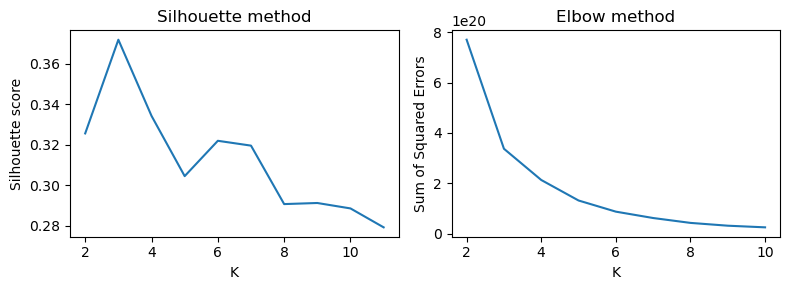

In [72]:
fig, ax = plt.subplots(1,2, figsize=(8,3))

sbplt = ax[0]
sbplt.plot(silhouettes.k,silhouettes.score)
sbplt.set_title("Silhouette method")
sbplt.set_ylabel('Silhouette score')
sbplt.set_xlabel('K')

sbplt = ax[1]
plot_sse(X)
sbplt.set_title("Elbow method")
    
fig.tight_layout()
plt.show()

In [74]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=3, random_state=42) #create model
labels = kmean.fit_predict(X_standard)

In [75]:
#dimensionality reduction with PCA
from sklearn.decomposition import PCA

X_reduced_pca = PCA(n_components=2).fit_transform(X_standard)

In [140]:
labels

array([1, 2, 2, ..., 2, 2, 1], dtype=int32)

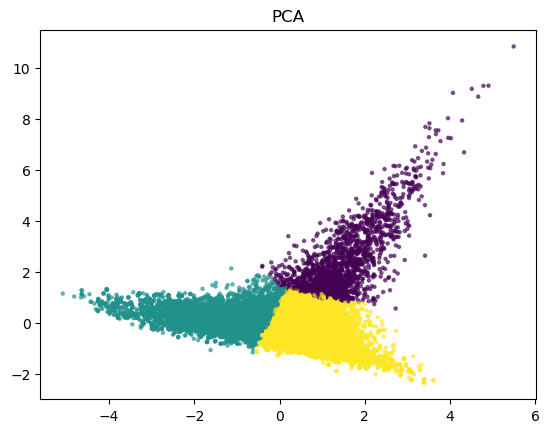

In [78]:
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6, s=5)
plt.title("PCA")    
fig.tight_layout()
plt.show()

In [80]:
actorMetrics['cluster'] = labels
#split dataset into clusters
k1 = actorMetrics[actorMetrics['cluster'] == 0]
k2 = actorMetrics[actorMetrics['cluster'] == 1]
k3 = actorMetrics[actorMetrics['cluster'] == 2]

In [83]:
pd.DataFrame({'cluster1': [k1.appearances.mean(),k1.appearances.median(),k1.grade_avg.mean(),k1.grade_avg.median(),
                     k1.revenue_avg.mean()/1e6,k1.revenue_avg.median()/1e6,len(k1)/len(actorMetrics)],
              'cluster2': [k2.appearances.mean(),k2.appearances.median(),k2.grade_avg.mean(),k2.grade_avg.median(),
                     k2.revenue_avg.mean()/1e6,k2.revenue_avg.median()/1e6,len(k2)/len(actorMetrics)],
              'cluster3': [k3.appearances.mean(),k3.appearances.median(),k3.grade_avg.mean(),k3.grade_avg.median(),
                     k3.revenue_avg.mean()/1e6,k3.revenue_avg.median()/1e6,len(k3)/len(actorMetrics)]},
             index=['Mean_appearances',
                    'Median_appearances',
                    'Mean_grade',
                    'Median_grade',
                    'Mean_revenue_[M$]',
                    'Median_revenue_[M$]',
                    'Fraction_of_actors'])

,cluster1,cluster2,cluster3
Mean_appearances,18.726386,1.847731,2.714487
Median_appearances,16.000000,1.000000,2.000000
Mean_grade,4.740345,3.708206,5.154258
Median_grade,4.747372,3.772282,5.080827
Mean_revenue_[M$],123.329682,23.808880,169.966638
Median_revenue_[M$],103.314770,12.552760,91.436512
Fraction_of_actors,0.074849,0.373837,0.551314


## networking
asses global efficiency of networks of top actors & rest

In [84]:
network = data[['actor', 'Movie_name']].copy()
network.head()

,actor,Movie_name
0,Dustin_Farnum,The Squaw Man
1,Elmer_Clifton,The Birth of a Nation
2,Robert_Harron,The Birth of a Nation
3,Walter_Long,The Birth of a Nation
4,Violet_Wilkey,The Birth of a Nation


In [85]:
frequencies = network.merge(
    network, on = 'Movie_name').groupby(['actor_x','actor_y']).size().unstack(
    'actor_y', fill_value = 0)

In [86]:
frequencies

actor_y,40_Glocc,50_Cent,A.D._Miles,A._J._Benza,A._J._Bowen,A._J._Buckley,A._J._Cook,A._J._Langer,A._Michael_Baldwin,A_Martinez,...,Özgü_Namal,Özgür_Çevik,Þröstur_Leó_Gunnarsson,İdil_Fırat,İsmail_Hacıoğlu,Şafak_Sezer,Şebnem_Dönmez,Željko_Ivanek,佐々木望,田村英里子
actor_x,,,,,,,,,,,,,,,,,,,,,
40_Glocc,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50_Cent,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A.D._Miles,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A._J._Benza,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A._J._Bowen,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Şafak_Sezer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
Şebnem_Dönmez,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
Željko_Ivanek,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,17,0,0


In [87]:
degrees = frequencies.astype('bool').sum(axis = 0) - 1

In [89]:
degrees_ordered = pd.DataFrame(degrees, columns = ['degree']).reindex(actorMetrics['actor'].values).reset_index()

In [90]:
actorMetrics['degree'] = degrees_ordered['degree']

In [91]:
actorMetrics

,actor,revenue_avg,grade_avg,revenue_sum,grade_sum,appearances,score_sum,EPFLsum,cluster,degree
0,Dustin_Farnum,6.117500e+06,2.861536,6.117500e+06,2.861536,1,16.678023,2.697314,1,0
1,Elmer_Clifton,1.250000e+09,4.791714,1.250000e+09,4.791714,1,22.513298,4.217113,2,13
2,Robert_Harron,1.250000e+09,4.791714,1.250000e+09,4.791714,1,22.513298,4.217113,2,13
3,Walter_Long,1.250000e+09,4.791714,1.250000e+09,4.791714,1,22.513298,4.217113,2,13
4,Violet_Wilkey,1.250000e+09,4.791714,1.250000e+09,4.791714,1,22.513298,4.217113,2,13
...,...,...,...,...,...,...,...,...,...,...
21919,Kathleen_Rose_Perkins,4.254150e+06,4.961153,4.254150e+06,4.961153,1,16.865044,2.746024,1,7
21920,Bo_Barrett,4.254150e+06,4.961153,4.254150e+06,4.961153,1,16.865044,2.746024,1,7
21921,Odeya_Rush,5.256953e+07,5.482188,5.256953e+07,5.482188,1,19.479151,3.426869,2,12
21922,Kendall_Ryan_Sanders,5.256953e+07,5.482188,5.256953e+07,5.482188,1,19.479151,3.426869,2,12


In [188]:
#Degrees of actors

ordered_values = degrees.sort_values(ascending = False).reset_index(drop = True)

In [189]:
ordered_values

0        799
1        740
2        690
3        647
4        634
        ... 
21919      0
21920      0
21921      0
21922      0
21923      0
Length: 21924, dtype: int64

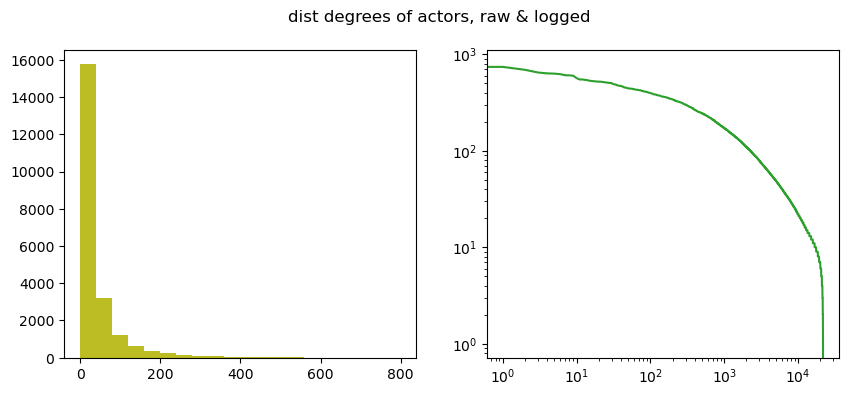

In [190]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
axs[0].hist(degrees, bins = 20, color = 'C8')

axs[1].loglog(ordered_values.index, ordered_values.values, color = 'C2')
fig.suptitle('dist degrees of actors, raw & logged')
plt.show()

>seems like a power law, respected clusters, with k1 most succesful actors having highest degrees seems to be exponential relationship between score & degree, the higher the score the more exponentially higher the degree

In [174]:
actorMetrics['logged_degree'] = np.log(actorMetrics['degree'] + 1)

In [175]:
k1 = actorMetrics[actorMetrics['cluster'] == 0]
k2 = actorMetrics[actorMetrics['cluster'] == 1]
k3 = actorMetrics[actorMetrics['cluster'] == 2]

clusters = [k1, k2, k3]

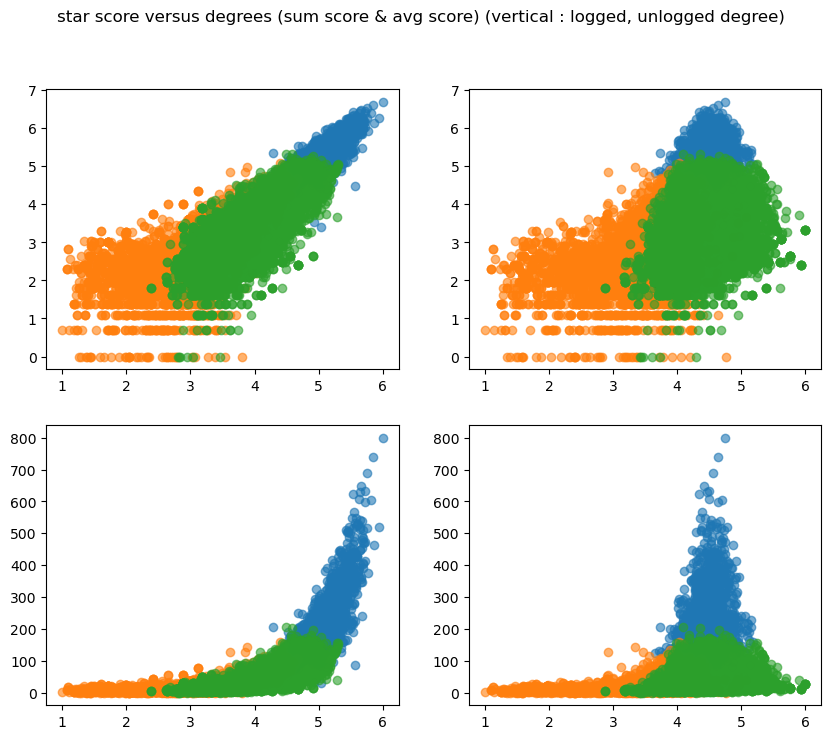

In [180]:
#matplotlib basic colors (blue k1, orange k2, green k3)
fig, axs = plt.subplots(2, 2, figsize = (10,8))
for idx, k in enumerate(clusters):
    axs[0,0].scatter(k['EPFLsum'], k['logged_degree'], color = 'C'+str(idx), alpha = 0.6)
    axs[0,1].scatter(k['EPFLavg'], k['logged_degree'], color = 'C'+str(idx), alpha = 0.6)
    axs[1,0].scatter(k['EPFLsum'], k['degree'], color = 'C'+str(idx), alpha = 0.6)
    axs[1,1].scatter(k['EPFLavg'], k['degree'], color = 'C'+str(idx), alpha = 0.6)

    
fig.suptitle('star score versus degrees (sum score & avg score) (vertical : logged, unlogged degree)')
plt.show()

>Degrees seems to definitely be a metric that qualifies the same clusters.

>degrees per actor is proportional to appearances, nothing special here
degrees favors casts with a large cast

In [178]:
import statsmodels.formula.api as smf #for linear and logistic regression

mod = smf.ols(formula='logged_degree ~ EPFLsum', data = actorMetrics)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          logged_degree   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                 4.696e+04
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        09:57:37   Log-Likelihood:                -18804.
No. Observations:               21924   AIC:                         3.761e+04
Df Residuals:                   21922   BIC:                         3.763e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7531      0.019    -40.492      0.0

In [ ]:
#show that sequels of movies have lower ratings
#keeps the same cast and decreases in 
#rating which shows a unsignificant correlation between appearances & imdb grades


In [51]:
import networkx as nx

In [104]:
Graph = nx.Graph()
Graph.add_nodes_from(frequencies.index)


for i in range(len(frequencies)):
    if (i%1000 == 0): print(i)
    for j in range(len(frequencies)):
        if (frequencies.iloc[i, j] != 0) & (i != j):
            Graph.add_edge(i, j, weight = frequencies.iloc[i, j])

'Graph = nx.Graph()\nGraph.add_nodes_from(frequencies.index)\n\n\nfor i in range(len(frequencies)):\n    if (i%1000 == 0): print(i)\n    for j in range(len(frequencies)):\n        if (frequencies.iloc[i, j] != 0) & (i != j):\n            Graph.add_edge(i, j, weight = frequencies.iloc[i, j])'

## total genre visualization & dendogram (NCC, next cell chungus)

In [38]:
genres_list = sum(list_to_join, [])

In [49]:
df_genres = pd.DataFrame({'genres' : genres_list}) #len 433190

In [50]:
df_genres.drop_duplicates() #308 genres

,genres
0,Silent film
1,Western
2,Drama
3,Indie
4,Black-and-white
...,...
396581,Nature
414077,News
414421,Fictional film
417054,Bloopers & Candid Camera


In [58]:
genre_occurences = pd.DataFrame(df_genres.groupby(['genres']).size(), columns = ['count'])

In [59]:
genre_occurences['count_percentage'] = genre_occurences['count']/len(df_genres)
display(genre_occurences)

,count,count_percentage
genres,,
Absurdism,732,0.001690
Acid western,29,0.000067
Action,18710,0.043191
Action Comedy,916,0.002115
Action Thrillers,2103,0.004855
...,...,...
Workplace Comedy,506,0.001168
World History,3,0.000007
World cinema,3450,0.007964


In [66]:
genre_occurences.sort_values(by ='count_percentage', ascending = False).head(50)

,count,count_percentage
genres,,
Drama,41556,0.095930
Comedy,33827,0.078088
Thriller,20337,0.046947
Romance Film,20180,0.046585
Action,18710,0.043191
Action/Adventure,14525,0.033530
Crime Fiction,13189,0.030446
Adventure,12871,0.029712
Family Film,9574,0.022101


## imdb stuff